In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
plt.rcParams['font.size'] = 14

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batch_size = 32
img_size = 224
directory = '/content/drive/Shareddrives/MushyMatch/ML/asset'
dataset_test = directory

datagen = ImageDataGenerator(rescale = 1/255.,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split = 0.15)

train_generator = datagen.flow_from_directory(directory,
                                             target_size = (img_size, img_size),
                                             batch_size = batch_size,
                                             shuffle=True,
                                             subset='training',
                                             class_mode = 'categorical')

validation_generator = datagen.flow_from_directory(directory,
                                             target_size = (img_size, img_size),
                                             batch_size = batch_size,
                                             shuffle=False,
                                             subset='validation',
                                             class_mode = 'categorical')

Found 490 images belonging to 4 classes.
Found 85 images belonging to 4 classes.


In [ ]:
[key for key in train_generator.class_indices]

['jamur enoki', 'jamur shimeji coklat', 'jamur shimeji putih', 'jamur tiram ']

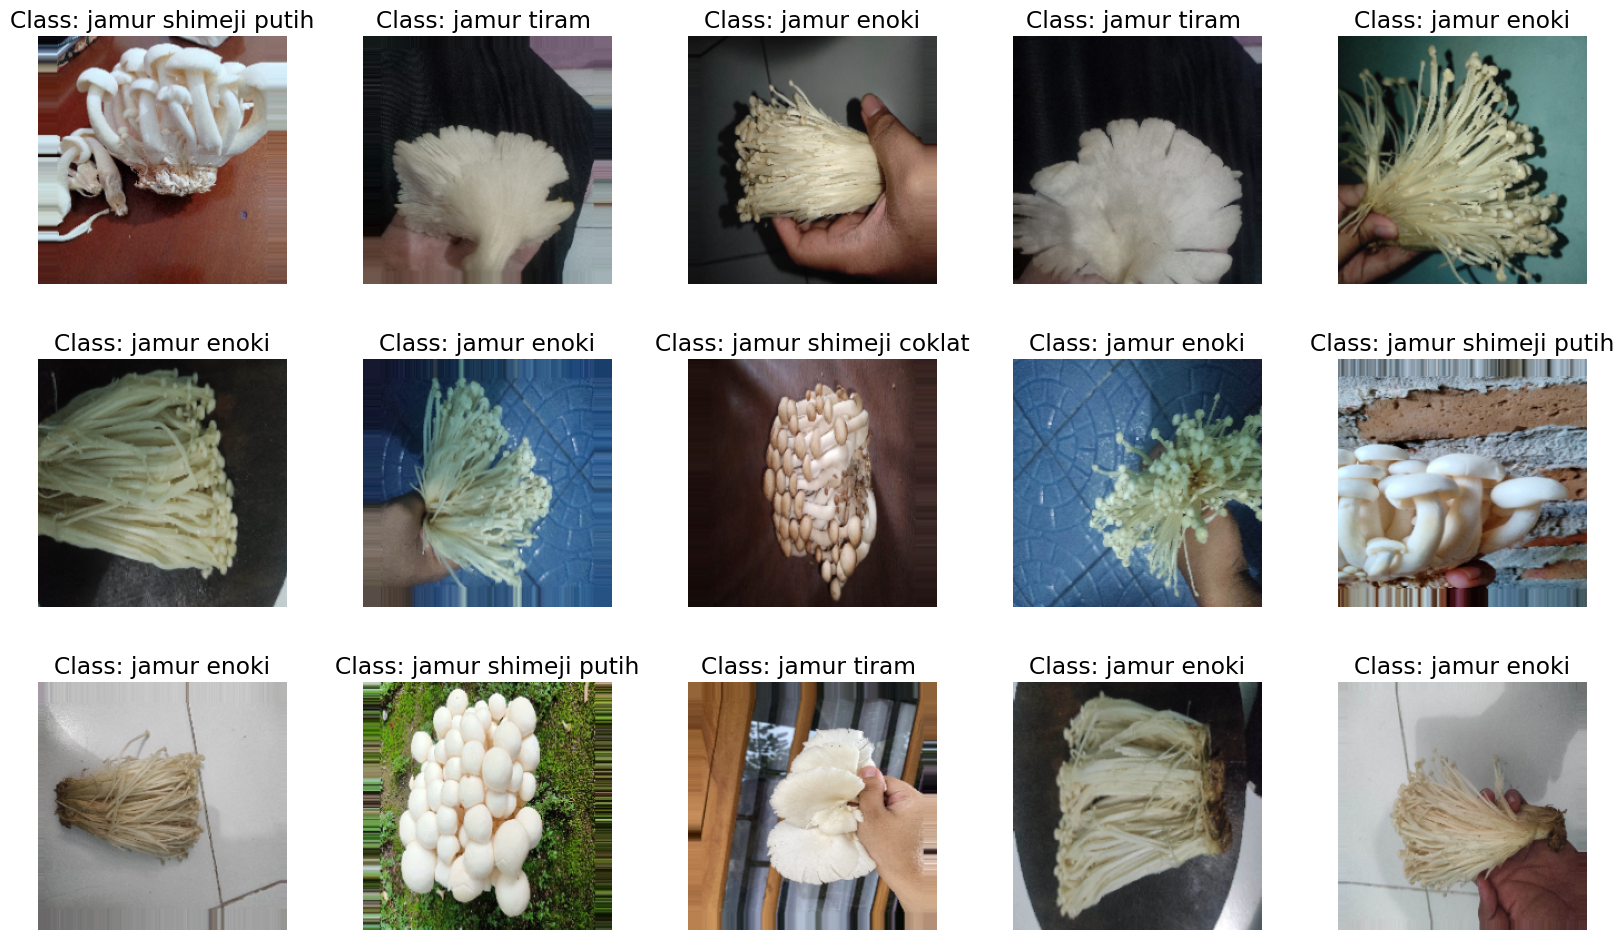

In [ ]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

 

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [ ]:
img_size = 224
base_model = VGG16(include_top = False,   # include_top is to include the classifier layer; whether to include the 3 fully-connected layers at the top of the network
                  weights = 'imagenet',
                  input_shape = (img_size, img_size, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base_model.layers

In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
model_name = 'model.h5'
checkpoint = ModelCheckpoint(model_name,
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1)

earlystopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)

In [ ]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(4, activation = 'softmax')(x)
model = Model(inputs = base_model.inputs, outputs = outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                   epochs = 10,
                   validation_data = validation_generator,
                   callbacks = [checkpoint, earlystopping])

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 0.8246 - accuracy: 0.7020 
Epoch 1: val_loss improved from inf to 0.95946, saving model to model.h5
16/16 [==============================] - 691s 42s/step - loss: 0.8246 - accuracy: 0.7020 - val_loss: 0.9595 - val_accuracy: 0.6941
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9265 
Epoch 2: val_loss did not improve from 0.95946
16/16 [==============================] - 640s 39s/step - loss: 0.1942 - accuracy: 0.9265 - val_loss: 1.5670 - val_accuracy: 0.6118
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9408 
Epoch 3: val_loss improved from 0.95946 to 0.92279, saving model to model.h5
16/16 [==============================] - 646s 40s/step - loss: 0.1499 - accuracy: 0.9408 - val_loss: 0.9228 - val_accuracy: 0.7412
Epoch 4/10
16/16 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9878 
Epoch 4: val_loss improved fro

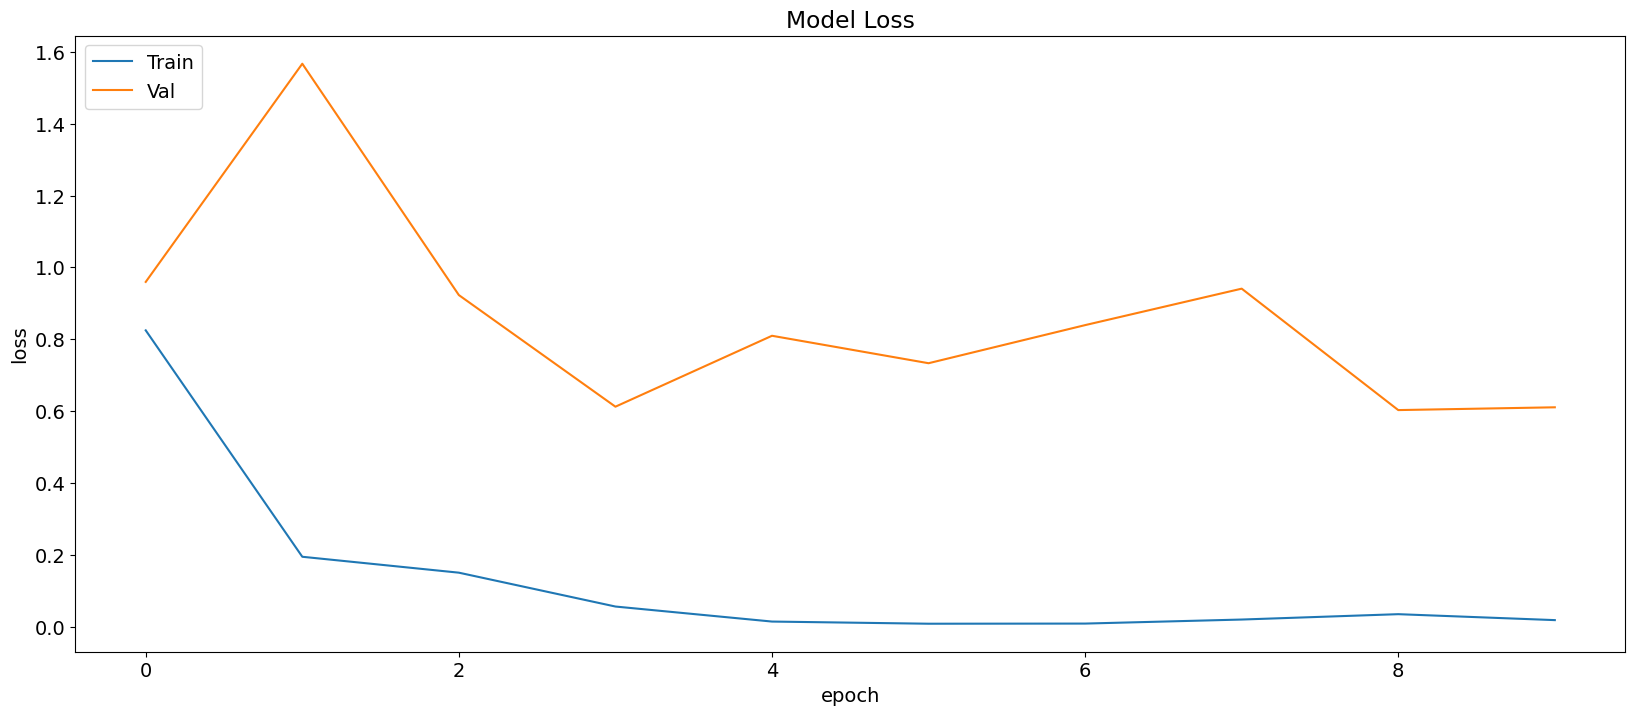

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

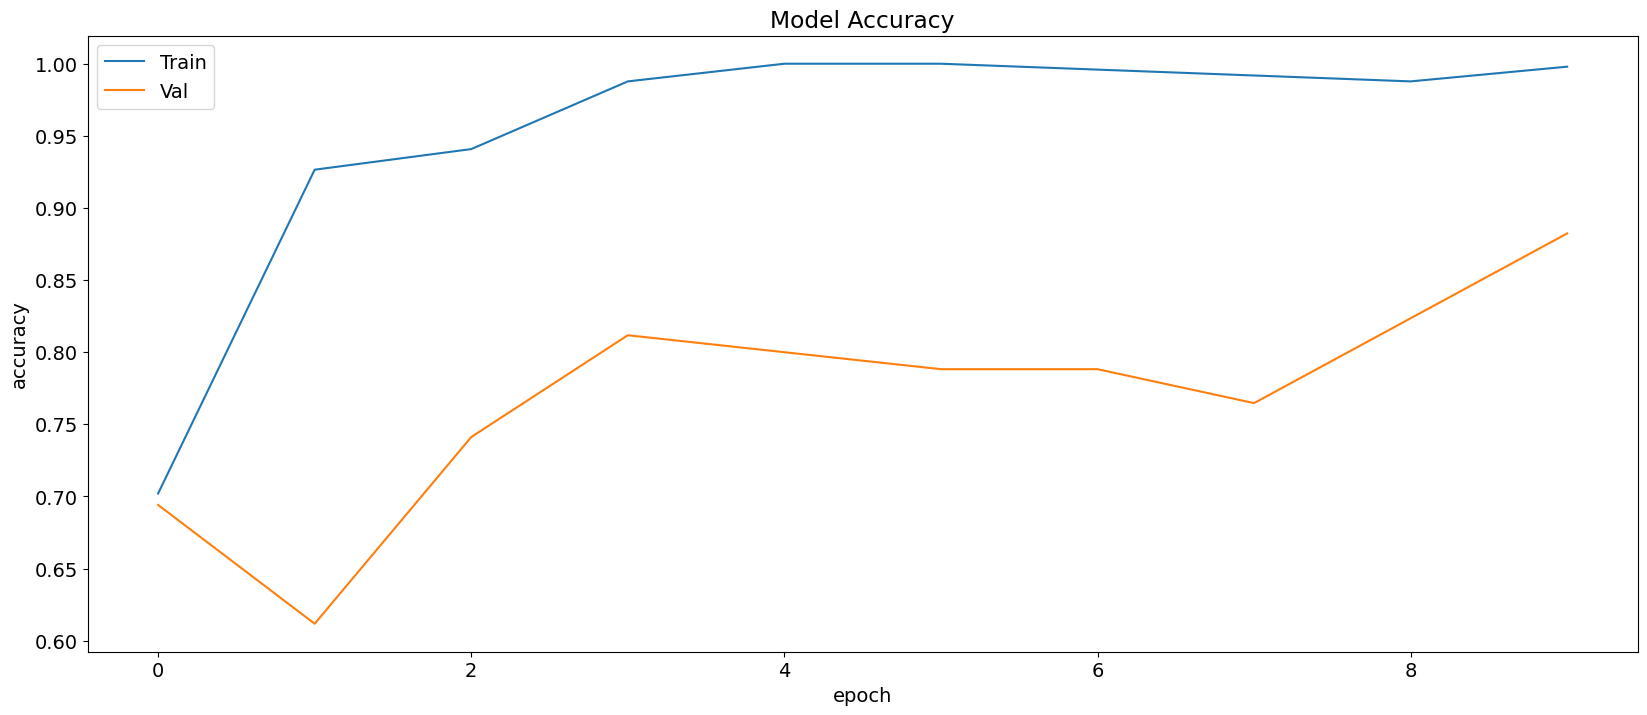

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
labels

['jamur enoki', 'jamur shimeji coklat', 'jamur shimeji putih', 'jamur tiram ']

In [ ]:
model = tf.keras.models.load_model('/content/model.h5')

In [ ]:
y_test = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_probs = y_pred.copy()

3/3 [==============================] - 85s 24s/step


In [ ]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=int32)

In [ ]:
y_pred_int = np.argmax(y_pred_probs, axis=1)

In [ ]:
print(classification_report(y_test,y_pred_int,target_names = labels))

                      precision    recall  f1-score   support

         jamur enoki       1.00      0.80      0.89        35
jamur shimeji coklat       0.54      1.00      0.70        15
 jamur shimeji putih       1.00      0.32      0.48        19
        jamur tiram        0.70      1.00      0.82        16

            accuracy                           0.76        85
           macro avg       0.81      0.78      0.72        85
        weighted avg       0.86      0.76      0.75        85



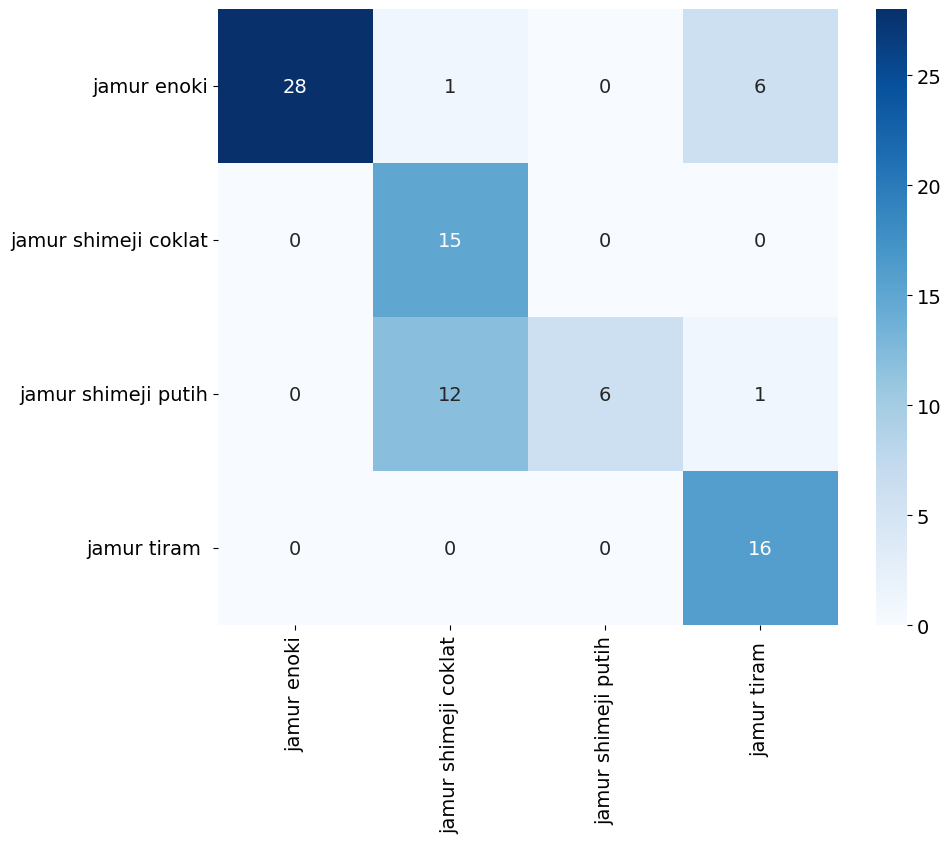

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred_int),annot=True,fmt='.3g',xticklabels=labels,
            yticklabels=labels,cmap='Blues')
plt.show()

**SAVING MODEL**

In [ ]:
model.save("YangJamurJamuraja_v2.h5")

**CONVERTING MODEL TO TFLITE**

In [ ]:
model.save("YangJamurJamuraja_v2")

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/Shareddrives/MushyMatch/ML/model/v2/YangJamurJamuraja_v2.h5')

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('YangJamurJamuraja_v2') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

**TRYING TFLITE WITH PYTHON**

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['input_1'], 'outputs': ['dense_1']}}


In [ ]:
# Load the TFLite model in TFLite Interpreter
interpreter = tf.lite.Interpreter("model.tflite")
# There is only 1 signature defined in the model,
# so it will return it by default.
# If there are multiple signatures then we can pass the name.
my_signature = interpreter.get_signature_runner()

# my_signature is callable with input as arguments.
output = my_signature(input_1 = tf.random.uniform((1, 224, 224, 3)))
# 'output' is dictionary with all outputs from the inference.
# In this case we have single output 'result'.
print(output['dense_1'])

[[0.66519725 0.28259248 0.01851091 0.03369934]]


**TESTING WITH IMAGES**

In [ ]:
import cv2

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/Shareddrives/MushyMatch/ML/model/v2/YangJamurJamuraja_v2.h5')

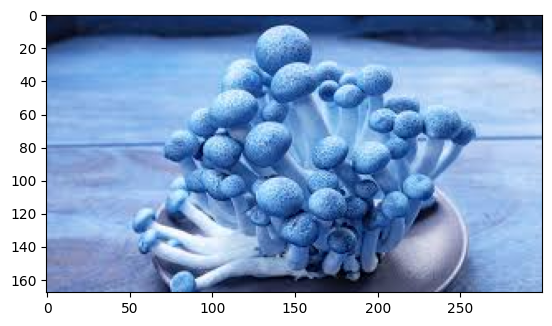

In [ ]:
img = cv2.imread('images (5).jpg')
plt.imshow(img)
plt.show()

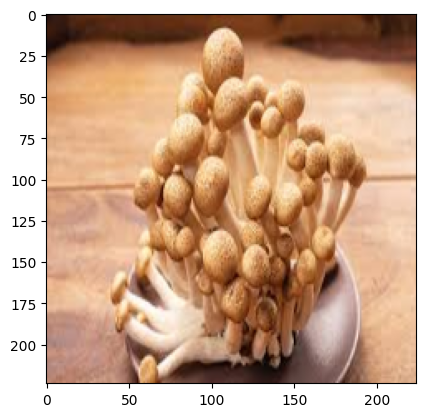

In [ ]:
resize = tf.image.resize(img, (224,224))
color_converted = (cv2.cvtColor(resize.numpy().astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.imshow(color_converted)

In [ ]:
color_converted = loaded_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 1s 1s/step


In [ ]:
color_converted.argmax()

1

ENOKI = 0 <br/>
SHIMEJI COKLAT = 1 <br/>
SHIMEJI PUTIH = 2 <br/>
TIRAM = 3 <br/>

**MAKING A FUNCTION FOR DEPLOYING**

In [1]:
im
print(tf. __version__)

NameError: ignored